# Семинар по визуализации, генерации признаков и общему плану решения практических задач

В этом практическом семинаре мы посмотрим на пример работы с набором от данных от первого взгляда на данные до построения модели. В ходе семинара обсудим важные шаги решения практической задачи: визуализируем и проанализируем данные, придумаем новые признаки на основе имеющихся, посмотрим, как строится базовое решение на основе xgboost и как подбираются гиперпараметры, как происходит отбор признаков.

За основу семинара взят [ноутбук с Kaggle Kernels](https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367/notebook), автор [@beluga](https://www.kaggle.com/gaborfodor).

В ноутбуке решается задача [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration), в которой по данным поездки на такси в Нью-Йорке необходимо предсказать продолжительность поездки. Для загрузки полных данных воспользуйтесь ссылкой на соревнование. Для семинара используется сокращенная версия данных с целью сократить время вычислений.

Цитата автора ноутбука:

My best single model with these features reached LB 0.371. Linear combination of several models gave LB 0.368. Stacking added marginal improvement to 0.367.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
#import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')

# Загрузка и простой анализ данных

In [2]:
np.random.seed(1987)
N = 100000
# для загрузки полных данных:
#train = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')
# для семинара используем часть датасета (чтобы ускорить вычисления)
train = pd.read_csv("https://github.com/nadiinchi/iad2020/raw/master/materials/train_sem_features.csv")
test = pd.read_csv("https://github.com/nadiinchi/iad2020/raw/master/materials/test_sem_features.csv")

Согласно описанию данных, у нас есть следующие признаки:

 - **id** - a unique identifier for each trip
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - duration of the trip in seconds

Конечно же, признаки dropoff_datetime and trip_duration доступны только для обучающей выборки.

In [3]:
print('We have {} training rows and {} test rows.'.format(train.shape[0], test.shape[0]))
print('We have {} training columns and {} test columns.'.format(train.shape[1], test.shape[1]))
train.head(2)

We have 100000 training rows and 50000 test rows.
We have 11 training columns and 9 test columns.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id3104769,2,2016-02-18 00:54:25,2016-02-18 01:20:38,1,-73.991730,40.745087,-73.909615,40.772057,N,1573
1,id2844283,1,2016-06-14 02:26:38,2016-06-14 02:39:39,1,-73.988205,40.718430,-73.886818,40.713310,N,781


Проанализируем id строк в обучении и контроле:

In [4]:
print('Id is unique.') if train.id.nunique() == train.shape[0] else print('oops')
print('Train and test sets are distinct.') if len(np.intersect1d(train.id.values, test.id.values))== 0 else print('oops')
print('We do not need to worry about missing values.') if train.count().min() == train.shape[0] and test.count().min() == test.shape[0] else print('oops')
print('The store_and_fwd_flag has only two values {}.'.format(str(set(train.store_and_fwd_flag.unique()) | set(test.store_and_fwd_flag.unique()))))

Id is unique.
Train and test sets are distinct.
We do not need to worry about missing values.
The store_and_fwd_flag has only two values {'Y', 'N'}.


Простейшая обработка данных: конвертируем признаки времени в datetime, бинаризуем признак, принимающий два значения:

In [5]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')

__Задание.__ Конвертируйте признак времени высадки пассажира в datetime:

In [6]:
# student's code here

Проверяем признак длины поездки в обучении:

In [7]:
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values  - train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

Trip_duration and datetimes are ok.


Максимальная длительность поездки:

In [13]:
# эта ячейка посчитана по полным данным, ее лучше не перезапускать :)
# ячейка выдает число 979
train['trip_duration'].max() // 3600

979

Максимальная длина поездки около 1000 часов. Видимо, поэтому выбрана метрика RMSLE (MSE для логарифма целевой переменной). Логарифмируем целевую переменную, чтобы далее работать только с ней:

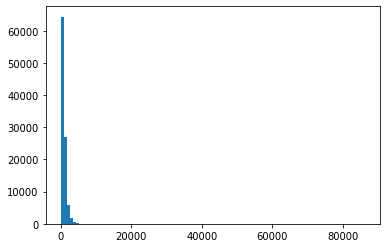

In [8]:
plt.hist(train['trip_duration'].values, bins=100);

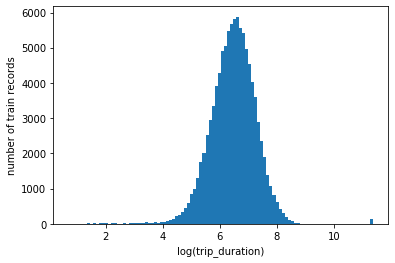

In [9]:
train['log_trip_duration'] = # your code here  # добавьте 1 к аргументу логарифма
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

## Выбор стратегии валидации

Проверяем разделение на обучение и контроль. Это даст нам больше понимания, как уcтраивать локальную валидацию модели, и поможет правильно выбрать, какие добавить признаки.

Какие дни присутствуют в обучении и контроле?

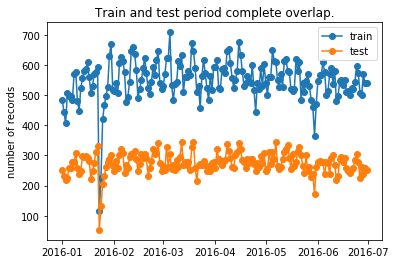

In [10]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

Какие координаты присутствуют в обучении и контроле?

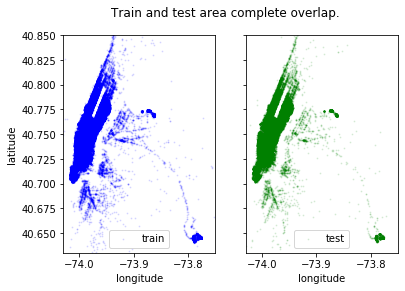

In [11]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:N], \
              train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:N], \
              test['pickup_latitude'].values[:N],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

Разделение на обучение и контроль случайное. Это позволяет не переживать насчет выделения локальных обучающей и контрольной выборок по времени или по координатам.

# Feature Extraction / Генерация новых признаков

## Признаки расстояния. PCA
Используем PCA для транформации широты и долготы. По утверждению автора ноутбука, поворот должен помочь найти лучшие разбиения в дереве. Уменьшение рамерности мы здесь не делаем.

Примените PCA (уже импортирован). Следуйте инструкциям в ячейке.

In [12]:
ar1 = train[['pickup_latitude', 'pickup_longitude']].values
ar2 = train[['dropoff_latitude', 'dropoff_longitude']].values
ar3 = test[['pickup_latitude', 'pickup_longitude']].values
ar4 = test[['dropoff_latitude', 'dropoff_longitude']].values

# Соедините все четыре массива в один по вертикали (по "объектам")
coords =  # your code here

# Создайте объект PCA
pca = # your code here

# Обучите PCA на координатах

pca.fit(coords)

# Применяем pca (вызываем transform и берем нулевой или первый столбец)
train['pickup_pca0'] = pca.transform(ar1)[:, 0]
train['pickup_pca1'] = pca.transform(ar1)[:, 1]
train['dropoff_pca0'] = pca.transform(ar2)[:, 0]
train['dropoff_pca1'] = pca.transform(ar2)[:, 1]
test['pickup_pca0'] = pca.transform(ar3)[:, 0]
test['pickup_pca1'] = pca.transform(ar3)[:, 1]
test['dropoff_pca0'] = pca.transform(ar4)[:, 0]
test['dropoff_pca1'] = pca.transform(ar4)[:, 1]

Для примера посмотрим, что получилось после трансформации PCA:

In [13]:
pca.transform(ar1)

array([[ 0.01875249, -0.00478313],
       [ 0.01728857, -0.03163238],
       [-0.03830517,  0.05120896],
       ...,
       [ 0.04541945, -0.03641789],
       [ 0.01534527, -0.001285  ],
       [ 0.03461587, -0.04168955]])

Визуализируем выполненную трансформацию с помощью PCA:

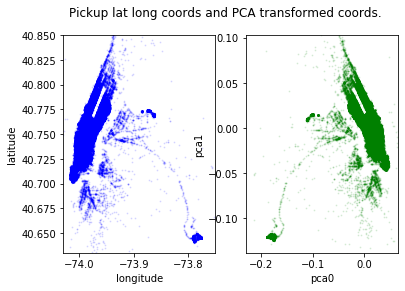

In [14]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, alpha=0.1)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N],
              color='green', s=1, alpha=0.1)
fig.suptitle('Pickup lat long coords and PCA transformed coords.')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()

## Признаки расстояния

Вычислим расстояния между местом посадки и высадки. Ниже используются сложные функции расстояния, не стоит сильно вникать в их код.  К примеру, используется расстояние на сфере - [Haversine distance](https://en.wikipedia.org/wiki/Haversine_formula). Кроме того, код вычисляет среднюю точку маршрута как дополнительный признак.

Цитата автора ноубука:

The cabs are not flying and we are in New York so we could check the Manhattan (L1) distance too :) 

In [15]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train['distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train['distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train['direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train['pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

test['distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test['distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test['direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test['pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

train['center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train['center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test['center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test['center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

Вычислите манхэттанское расстояние (модуль разности широт плюс модуль разности долгот):

In [11]:
# student's code here
train["distance_manhattan"] = 
test["distance_manhattan"] = 

## Признаки времени

Посчитаем простые функции по времени: выделим день недели, час, время, сравним дни и часы высадки и посадки:

In [17]:
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday
train['pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_minute'] = train['pickup_datetime'].dt.minute
train['pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train['pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test['pickup_weekday'] = test['pickup_datetime'].dt.weekday
test['pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_minute'] = test['pickup_datetime'].dt.minute
test['pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test['pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

## Скорость
Скорость - простой производный признак от двух предыдущих.

Вычислите скорость для трех функий расстояния. Вам понадобятя следующие признаки: distance_haversine, distance_dummy_manhattan, distance_manhattan, trip_duration.

In [13]:
# student's code here
train['avg_speed_h'] = 
train['avg_speed_dm'] = 
train['avg_speed_m'] = 

Посмотрим на скорость как на функцию от времени:

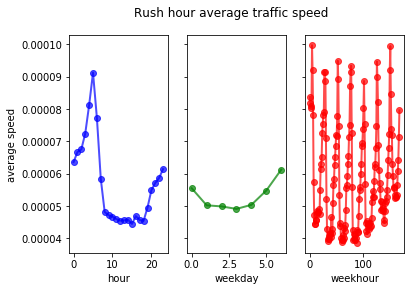

In [19]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_m'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_m'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_m'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

Все зависимости логичны.

Посмотрим на скорость как на функцию от геопозиции:

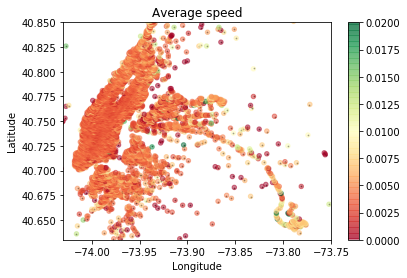

In [20]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
#coord_stats = coord_stats[coord_stats['id'] > 100]
plt.scatter(train.pickup_longitude.values, train.pickup_latitude.values,
           color='black', s=1, alpha=0.5)
plt.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values,
           c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=0, vmax=0.02)
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Average speed')
plt.colorbar()
plt.show()

train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 2)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 2)
train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_long_bin'] = np.round(train['center_longitude'], 2)
train.loc[:, 'pickup_dt_bin'] = (train['pickup_dt'] // (3 * 3600))
test.loc[:, 'pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['pickup_longitude'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600))

## Признаки на основе кластеризации

Кластеризация помогает лучше понять структуру данных. Поэтому ее часто используют для задания новых признаков: кластеризуют объекты по уже имеющимся признакам, кластеризуют геопозиции или множественнозначные признаки. Выполним кластеризацию геопозиций, чтобы выделить "районы", и добавим признаки района прибытия и района отправления:

In [21]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])
# coords is defined in PCA section

Добавьте признаки pickup_cluster и dropoff_cluster в обучающую и тестовую выборки:

In [21]:
# student's code here 


Визуализируем полученные "районы":

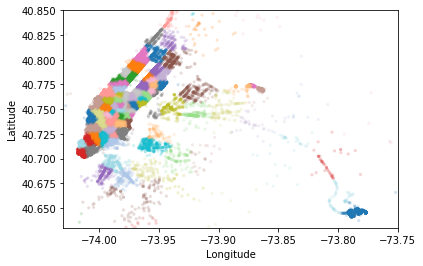

In [24]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N], s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

## Агрегация по времени и району

Добавим признаки, характеризующие среднюю скорость в данный момент времени или в данном (условном) районе. Таким образом мы закодируем категориальные признаки и добавим полезную информацию о поездке. 
Также добавим признаки средней скорости в комбинации район-момент времени, при этом удаляя редкие значения комбинации.

Важно, что в задаче не нужно учитывать разделение выборки по времени или по геопозиции, иначе к заданию указанных признаков нужны было бы подходить осторожнее.

In [25]:
# перебираем категориальные признаки, которые будем кодировать
for gby_col in ['pickup_hour', 'pickup_date', 'pickup_dt_bin',
               'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    # вычисляем средюю скорость и среднюю продолжительность поездки
    gby = train.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_dm', 'log_trip_duration']]
    # задаем имена новых признаков
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    # добавляем новые признаки: одно и то же значение из gby будет вставлено в несколько строк train и test
    train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)

# перебираем комбинации локация-момент времени и локация-локация
for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'pickup_cluster'],  ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    # вычисляем среднюю скорость и число объектов для комбинации
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    # удаляем редкие значения комбинации
    coord_stats = coord_stats[coord_stats['id'] > 100]
    # задаем имена новых стобцов
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    # добавляем новые признаки
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)

Ниже добавляются еще более сложно вычисляемые признаки, основанные на похожих идеях:

In [28]:
group_freq = '60min'
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
train.loc[:, 'pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
test.loc[:, 'pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)

# Count trips over 60min
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']
train = train.merge(df_counts, on='id', how='left')
test = test.merge(df_counts, on='id', how='left')

# Count how many trips are going to each cluster over time
dropoff_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.Grouper(freq=group_freq), 'dropoff_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('dropoff_cluster').rolling('240min').mean() \
    .drop('dropoff_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'dropoff_cluster_count'})

train['dropoff_cluster_count'] = train[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)
test['dropoff_cluster_count'] = test[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)

In [29]:
# Count how many trips are going from each cluster over time
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
pickup_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.Grouper(freq=group_freq), 'pickup_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('pickup_cluster').rolling('240min').mean() \
    .drop('pickup_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'pickup_cluster_count'})

train['pickup_cluster_count'] = train[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)
test['pickup_cluster_count'] = test[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)

Далее автор ноутбука выполняет проверку признаков, обучает модель, анализирует важности признаков и делает подбор гиперпараметров. Мы не будем запускать эти операции на семинаре, а просто посмотрим на результат в [оригинальном ноутбуке](https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367/notebook).

На что обратить внимание:

- Перед Feature check before modeling удаляются ненужные признаки: ID, дата (из нее извлекли всю информацию), pickup_lat_bin и pickup_lon_bin (они использовались для задания других признаков) и т. д.. Также задается целевая перемнная.

- В секции Feature check before modeling производится проверка, есть ли пропуски в данных и велик ли разрыв между обучающей и тестовой выборкой. Второе нужно, чтобы удостовериться, что распределение данных в обучении и тесте похожее, а также позволяет проверить, что в коде генерации признаков (вероятно) нет ошибок.

- В секции Modeling строится базовая модель xgboost с некоторыми гиперпараметрами и максимум 60 деревьями, выводится качество этой модели (используется метрика задачи).

- В секции Feature importance analysis автор ноутбука смотрит, какие важности присвоены признакам моделью. Важности довольно интерпретируемы: например, расстояние и место посадки сильно влияет на целевую переменную (время поездки), а vendor_id и store_and_fwd_flag - неважные признаки. Среди важных признаков много сгенерированных в процессе feature engineering.  Автор предлагает также посмотреть на другую характеристику важности признака - качество модели, построенной на всех данных, кроме признака. Данная мера качества не всегда совпадает с важностями, выданными xgboost, хотя в целом коррелирует. Стоит аккуратно относиться к важностям признаков, так как ни один метод не является "точно правильным".

- В секции XGB Parameter Search Result автор задает большую сетку гиперпараметров и поочередно выбирает случайную комбинацию. Такой случайный поиск позволяет покрыть разнообразные комбинации и найти хорошую область гиперпараметров.